# Using ```topicmod``` functions to easily apply topic modelling LDA and NMF techniques to text data stored in ```pandas.DataFrame``` 

In this example script, we show how ```nlpfunctions.topicmod``` functions can make it easy to apply Latent Derichlet Analysis (LDA) and Non-negative Matrix Factorization (NMF) models to text data and store the results in ```pandas.DataFrame``` so that they can be used in other analyses and explorations.

We will:
1. A
2. B
3. C
4. D

## Set ups and Imports

Import modules and our user-defined functions

In [1]:
import os
import re
import time
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from nltk import word_tokenize
from random import shuffle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from nlpbumblebee.utils import *
from nlpbumblebee.basicnlp import *
from nlpbumblebee.nlppipelineutils import *
from nlpbumblebee.topicmod import *

from gensim import models, corpora    #lda

from sklearn import decomposition     #nmf



In [2]:
pd.set_option('display.max_colwidth', -1)

## Data

We will use the same labelled text data as in Example 2 and 3 from "From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015" (available here)

In [3]:
#df = pd.read_excel('Data/imdb.xlsx', header=0)
df = pd.read_excel('Data/yelp_labelled.xlsx', header=0)

#df['source'] = 'imdb'
df['source'] = 'yelp'

df[df.duplicated('text')]
df = df.drop_duplicates('text')

df[pd.isnull(df['text'])]   #yep, 1 case
df = df[pd.notnull(df['text'])]   

In [4]:
print(df.head())

                                                                                      text  \
0  Wow... Loved this place.                                                                  
1  Crust is not good.                                                                        
2  Not tasty and the texture was just nasty.                                                 
3  Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.   
4  The selection on the menu was great and so were the prices.                               

   score source  
0  1      yelp   
1  0      yelp   
2  0      yelp   
3  1      yelp   
4  1      yelp   


### Word frequency

Let's take a look at the most frequent words

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
word,the,and,I,was,a,to,The,is,of,for,...,place,with,had,be,are,were,very,that,have,so
count,404,378,291,290,227,213,176,170,123,102,...,76,71,65,64,62,61,60,59,59,58


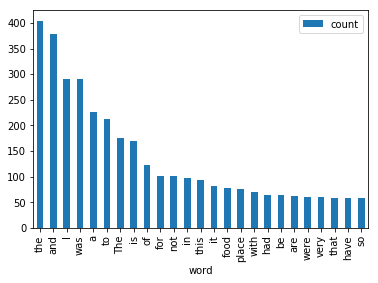

In [5]:
# Plot most frequent words

# https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
all_words = df['text'].str.split(expand=True).unstack().value_counts()
all_words = all_words.to_frame().reset_index().rename(columns = {'index' : 'word', 0 : 'count'})

# get 25 more frequent words
all_words[:25].plot.bar(x='word')
all_words[:25].T

#lots of "rubbish"...

### Clean text data for topic modelling


We will:
1. tokenise
2. lower case
3. remove stopwords
4. remove non-alphabetic tokens (i.e., punctuations and numbers)
5. lemmatise

In [6]:
preprocessing_pipe = combine_functions(sent_tokenise
                                       ,remove_punctuation
                                       ,word_tokenise
                                       ,to_lower
                                       ,POS_tagging
                                       ,lemmatise
                                       ,fix_neg_auxiliary
                                       ,lambda s: [[re.sub(r'\d+','',x) for x in subs] for subs in s]
                                       ,lambda x : remove_stopwords(x, extra_stopwords = [
                                           'x', "'s", "not", 'us', 'no', 'many', 'much', 'one', 'put', 've',
                                           'wo', 'even', 'first', 'may', 'late', 'come', 'iam', 'ive', 'ill',
                                           'good', 'bad', 'great', 'sure', 'best', 'quite', 'per', 'due', 'always',
                                           'say', 'want', 'm', 'ever', 'every', 'really', 'well', 'little', 'd',
                                           'also', 'get', 'would', 'could', 'like', 'go', 'lot', 'make'])
                                       ,flattenIrregularListOfLists
                                       ,lambda x: list(filter(None, x))
                                      )   

In [7]:
df['text_lemmas'] = df['text'].apply(lambda x: preprocessing_pipe(x))

# check some texts
df[['text', 'text_lemmas']][:5]

,text,text_lemmas
0,Wow... Loved this place.,"[wow, love, place]"
1,Crust is not good.,[crust]
2,Not tasty and the texture was just nasty.,"[tasty, texture, nasty]"
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,"[stop, bank, holiday, rick, steve, recommendation, love]"
4,The selection on the menu was great and so were the prices.,"[selection, menu, price]"


### Lemma frequency

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
word,food,place,service,back,time,eat,love,wait,dont,restaurant,...,think,experience,taste,im,minute,staff,price,pretty,pizza,definitely
count,123,110,84,60,55,31,30,29,28,28,...,22,21,21,21,19,19,19,19,18,18


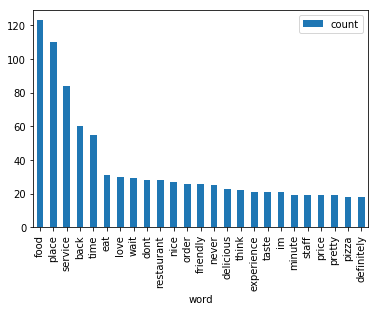

In [8]:
# re-plot most frequent words

all_lemmas = df['text_lemmas'].apply(list2string).str.split(expand=True).unstack().value_counts()
all_lemmas = all_lemmas.to_frame().reset_index().rename(columns = {'index' : 'word', 0 : 'count'})

# get 25 more frequent lemmas
all_lemmas[:25].plot.bar(x='word')
all_lemmas[:25].T

# much better!

## Topic modelling with Latent Dirichlet Analysis (LDA)

LDA is a topic discovery technique. It is a generative statistical topic model used to find accurate sets of topics within a given document set. The model assumes that text documents are comprised of a mixture of topics, and each topic is represented as the probability that each of given set of terms will occur. From there, using probability distributions the model can determine which topics are in a given document and which words are in a given topic based on word prevalence across topics and topic prevalence across document. A unique feature of LDA models is that topics are not required to be distinct, and words may occur in multiple topics

Ref: 

https://medium.com/square-corner-blog/topic-modeling-optimizing-for-human-interpretability-48a81f6ce0ed

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

**Please note**: As of today, September 2018, there seems to be a bug introduced in a recent version of ```gensim```, the way it interacts with ```numpy``` which is used for all the computations. Downgrading to gensim 3.1.0 seems to solve the problem (ref: https://github.com/RaRe-Technologies/gensim/issues/2115).
To do this please type ```$ pip install gensim==3.1.0``` in your Terminal.


### (1) Create a dictionary containing the number of times a word appears in the corpus of texts

In [9]:
# Build a Dictionary = association word to numeric id
# assigning a unique integer id to each unique word while also collecting word counts and relevant statistics. 
dictionary = corpora.Dictionary(df['text_lemmas'])

In [10]:
# what's the vocabulary size?
print(len(dictionary.token2id.keys()))

# take a look (first 25 entries in the dictionary)
#for k, v in dictionary.token2id.items(): 
#    print("{} : {}".format(k, v))

1640


### (2) Filter out words that occur too frequently or too rarely.

When dealing with a bigger corpus than the one used in his example, you may want to further clean the text data by excluding words that occur in:
- less than X texts (absolute number) or (infrequent words)
- more than 0.p documents (fraction of total corpus size, not absolute number) (too frequent words).
- after the above two steps, keep only the first 100000 most frequent tokens.

In [11]:
min_wordcount = 10
max_freq = 0.6

dictionary.filter_extremes(no_below=min_wordcount,
                            no_above=max_freq,
                            keep_n=100000)

Let's see what our dictionary size has become now...

In [12]:
print(len(dictionary.token2id.keys()))
#...  too harsh filtering?

79


### (3) From texts as documents to Document Term Matrix

Transform the collection of texts to a numerical form: For each text, report how many many times each occurring word appears. I.e., Convert the list of documents (corpus) into a Document Term Matrix using the dictionary prepared above.


In [13]:
bow_corpus = [dictionary.doc2bow(text) for text in df['text_lemmas']]

In [14]:
print(type(bow_corpus))
print(len(bow_corpus))
print(bow_corpus[:5])

<class 'list'>
993
[[(0, 1), (1, 1)], [], [(2, 1)], [(0, 1)], [(3, 1), (4, 1), (5, 1)]]


In [15]:
# Have a look at how the 1st text looks like: [(word_id, count), ...]

print( df[['text', 'text_lemmas']][1:2] )
print( bow_corpus[1] )

for i in range(len(bow_corpus[1])):
    print("Word {} (\"{}\") appears {} time.".format(bow_corpus[1][i][0],
          dictionary[bow_corpus[1][i][0]], 
          bow_corpus[1][i][1]))


                 text text_lemmas
1  Crust is not good.  [crust]   
[]


### (4) Find the best number of topics

#### Perplexity

Perplexity is a standard measure for estimating the performance of a probabilistic model: it measures how well the probabilistic model predicts a sample. The perplexity of a set of test words, is defined as the exponential of the negative normalized predictive likelihood under the model. 

One should expect "in-sample" perplexity to improve with more topics, but that the improvement would level off as the model captures all but the most trivial structures in the data. So the ideal number of topics should be the poin where perplexity starts to level off. 

Ref: 

https://docs.google.com/viewer?a=v&pid=forums&srcid=MDEwMDM0NjcxOTk3Njc0MTA0MjMBMTQzMzY3Nzc1NTMzNDgyNjIyMzEBZnBOMFVLSG9BZ0FKATAuMwEBdjI&authuser=0

https://groups.google.com/forum/#!topic/gensim/BDuOnCGpgOs

http://qpleple.com/perplexity-to-evaluate-topic-models/

https://groups.google.com/forum/#!topic/gensim/TpuYRxhyIOc


**Important**: However, please note that it has been shown that perplexity doesn't correlate well with human judgements of topic coherence. 

Other coherence measures have been suggested that have performed better. Example: https://www.kdnuggets.com/2016/07/americas-next-topic-model.html


TODO: turn this into a function


In [16]:
# (i) divide corpus in training and test corpus. The test corpus will be used to calculate perplexity
    
shuffle(bow_corpus)

train_corpus, test_corpus = bow_corpus[:800], bow_corpus[800:]

# Number of words in the training set and in the test set
print(sum(cnt for document in train_corpus for _, cnt in document))
print(sum(cnt for document in test_corpus for _, cnt in document))


1311
299


In [17]:
train_corpus[:2]

[[(19, 1), (45, 1)], [(15, 1)]]

In [18]:
# (ii) loop on training set for several numbers of topics: 
topics_seq = list((2,3,4,5,7,8,9,10, 15, 20, 25, 30, 35))

results_perplexity = {}
for topic_n in topics_seq:
    start_time = time.time()
    # run model
    print('number of topics :  %d' % topic_n)
    
    model = models.LdaModel(corpus=train_corpus
                             , num_topics=topic_n
                             , id2word=dictionary
                             , passes = 20  # as we have a small corpus
                             , eta = 0.01 # topics are known to be word-sparse, the Dirichlet parameter of the word distributions is set small (e.g., 0.01), in which case learning is efficient.
                             , alpha = 0.1    #believed that each document is associated with few topics
                             , random_state = 1
                             )
    elapsed = time.time() - start_time
    
    # perplexity on hold-out test data
    log_perplexity = model.log_perplexity(test_corpus)              # this is actually per-word likelihood bound
    perplexity_test = np.exp(-log_perplexity.astype(np.float64))    # https://stats.stackexchange.com/a/324243
    
    print('per-word likelihood bound     ', log_perplexity)
    print('perplexity : exp(-bound)                             ', perplexity_test)
    print('elapsed time: %.3f' % elapsed)  
    print( ' ')
    results_perplexity[topic_n] = perplexity_test
    


number of topics :  2


/home/michaela/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


per-word likelihood bound      -6.057575934881151
perplexity : exp(-bound)                              427.3382844753499
elapsed time: 3.489
 
number of topics :  3
per-word likelihood bound      -6.240780424114853
perplexity : exp(-bound)                              513.2589143141769
elapsed time: 3.228
 
number of topics :  4
per-word likelihood bound      -6.35142970354262
perplexity : exp(-bound)                              573.3117892493092
elapsed time: 3.372
 
number of topics :  5
per-word likelihood bound      -6.458772560126805
perplexity : exp(-bound)                              638.2771287578629
elapsed time: 3.418
 
number of topics :  7
per-word likelihood bound      -6.477651982502794
perplexity : exp(-bound)                              650.4419028944502
elapsed time: 3.483
 
number of topics :  8
per-word likelihood bound      -6.490411871153375
perplexity : exp(-bound)                              658.7946458552644
elapsed time: 3.643
 
number of topics :  9
per-w

In [19]:
results_perplexity

{2: 427.3382844753499,
 3: 513.2589143141769,
 4: 573.3117892493092,
 5: 638.2771287578629,
 7: 650.4419028944502,
 8: 658.7946458552644,
 9: 694.3195946662776,
 10: 703.4753628471663,
 15: 553.7099378782061,
 20: 595.9121049328121,
 25: 647.3506143024748,
 30: 672.3515333473423,
 35: 446.54067558292076}

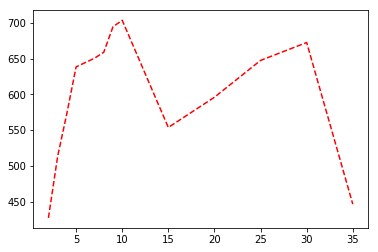

In [20]:
# plot of perplexity versus number of topics
plt.plot(results_perplexity.keys(), results_perplexity.values(), 'r--',)

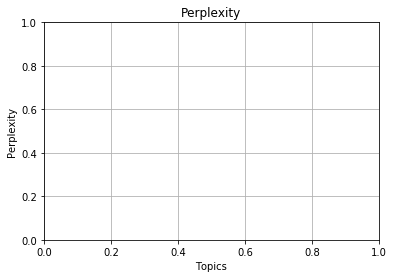

In [21]:
plt.title('Perplexity')
plt.xlabel('Topics')
plt.ylabel('Perplexity')
plt.grid(True) 
plt.show()

# Perplexiy seems to suggest 8 topics: 

### (5) Build an lda model with the suggested number of topics

In [22]:
# Build the lda model with the suggested number of topics

NUM_TOPICS = 8

lda_model_1 = models.LdaModel(corpus=bow_corpus
                             , num_topics=NUM_TOPICS
                             , id2word=dictionary
                             , passes = 20  # as we have a small corpus
                             , eta = 0.01 # topics are known to be word-sparse, the Dirichlet parameter of the word distributions is set small (e.g., 0.01), in which case learning is efficient.
                             , alpha = 0.1    #believed that each document is associated with few topics
                             )


/home/michaela/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


### (6) Explore topics

To inspect the topics, we will look at each topic in terms of the words it has the highest probability to generate

In [23]:
# (iv) Explore Topics

print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 5 most representative words for each topic
    print("Topic #%s:" % idx, lda_model_1.print_topic(idx, 5))
 
print("=" * 20)

# Really hard to understand the topics...


LDA Model:
Topic #0: 0.194*"time" + 0.133*"order" + 0.108*"experience" + 0.087*"chicken" + 0.078*"place"
Topic #1: 0.438*"place" + 0.135*"eat" + 0.107*"delicious" + 0.105*"food" + 0.051*"awesome"
Topic #2: 0.349*"food" + 0.294*"service" + 0.067*"minute" + 0.046*"thing" + 0.042*"buffet"
Topic #3: 0.155*"wait" + 0.151*"restaurant" + 0.113*"im" + 0.086*"salad" + 0.086*"menu"
Topic #4: 0.120*"dont" + 0.102*"taste" + 0.092*"pretty" + 0.088*"pizza" + 0.082*"dish"
Topic #5: 0.107*"steak" + 0.101*"disappointed" + 0.097*"burger" + 0.088*"flavor" + 0.088*"fresh"
Topic #6: 0.310*"back" + 0.129*"never" + 0.113*"think" + 0.093*"definitely" + 0.093*"wont"
Topic #7: 0.150*"nice" + 0.145*"friendly" + 0.106*"staff" + 0.100*"star" + 0.089*"give"


The python package ```pyLDAvis``` is designed to help the interpretion of the topics in a topic model. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization (https://datascienceplus.com/topic-modeling-in-python-with-nltk-and-gensim/).

In [24]:
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model_1, bow_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/michaela/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


**Saliency**: a measure of how much the term tells you about the topic.

**Relevance**: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.

The **size** of the bubble measures the importance of the topics, relative to the data.

In [25]:
?remove_stopwords

### (7) Test on new text data

In [26]:
# let's try on a new (invented) text
text_test = ['time', 'waste', 'food', 'staff', 'back', 'definitely']
text_test_bow = dictionary.doc2bow(text_test)

lda_model_1.get_document_topics(bow = text_test_bow)
list(lda_model_1[text_test_bow])


[(0, 0.017260833),
 (1, 0.01724369),
 (2, 0.18951832),
 (3, 0.017246092),
 (4, 0.017241381),
 (5, 0.017241381),
 (6, 0.53268766),
 (7, 0.19156067)]

## Create dataframe of topic probabilities 

Here we will use ```topicmod.lda_dtm2df``` to create a dataframe in which:
- each row represents a document/text
- has one column for each topic containing the probability of that topic for each document

In [27]:
DTM_df = lda_dtm2df(lda_model_1[bow_corpus], 8)

In [28]:
DTM_df.head()

,t0_lda,t1_lda,t2_lda,t3_lda,t4_lda,t5_lda,t6_lda,t7_lda
0,0.035714,0.749976,0.035738,0.035714,0.035714,0.035714,0.035714,0.035714
1,0.055556,0.055556,0.055556,0.055556,0.611111,0.055556,0.055556,0.055556
2,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.815789
3,0.026316,0.026319,0.289463,0.026316,0.026316,0.289474,0.289481,0.026316
4,0.055556,0.055556,0.055556,0.611111,0.055556,0.055556,0.055556,0.055556


## Create dataframe of topics' top n words and their probabilities

Here we will use ```topicmod.lda_topic_top_words``` to create a dataframe in which:
- each row represents a document/text
- columns contains a list of that topic's top n words and a list of their the probability for that topic

In [29]:
# (iv) extract top n words and their probabilities for each topic, turn them into a dataframe

words_topics_dict = lda_topic_top_words(lda_mod = lda_model_1, n_top_words = 6)
words_topics_df = topictopwords_dict2df(words_topics_dict, orig_dataset = df, tech = 'lda')

words_topics_df.head()

,t0_top_words_lda,t1_top_words_lda,t2_top_words_lda,t3_top_words_lda,t4_top_words_lda,t5_top_words_lda,t6_top_words_lda,t7_top_words_lda,t0_top_word_pbs_lda,t1_top_word_pbs_lda,t2_top_word_pbs_lda,t3_top_word_pbs_lda,t4_top_word_pbs_lda,t5_top_word_pbs_lda,t6_top_word_pbs_lda,t7_top_word_pbs_lda
0,"[time, order, experience, chicken, place, recommend]","[place, eat, delicious, food, awesome, find]","[food, service, minute, thing, buffet, slow]","[wait, restaurant, im, salad, menu, table]","[dont, taste, pretty, pizza, dish, love]","[steak, disappointed, burger, flavor, fresh, fantastic]","[back, never, think, definitely, wont, meal]","[nice, friendly, staff, star, give, price]","[0.19427764, 0.13270135, 0.107623115, 0.087046705, 0.07792143, 0.066655315]","[0.4375628, 0.13480526, 0.10742526, 0.10453638, 0.051379252, 0.04631667]","[0.3490215, 0.2941262, 0.06666314, 0.04562829, 0.04212442, 0.038519986]","[0.15536971, 0.15112151, 0.11259605, 0.08620191, 0.086186044, 0.075210355]","[0.11969008, 0.10225051, 0.092205025, 0.08766023, 0.0820418, 0.080893]","[0.10662046, 0.10078241, 0.096626334, 0.088223964, 0.08821183, 0.07476828]","[0.30979413, 0.12904908, 0.11348158, 0.09295596, 0.092954315, 0.07232885]","[0.14963323, 0.1449492, 0.10594377, 0.10037849, 0.089102834, 0.05579701]"
1,"[time, order, experience, chicken, place, recommend]","[place, eat, delicious, food, awesome, find]","[food, service, minute, thing, buffet, slow]","[wait, restaurant, im, salad, menu, table]","[dont, taste, pretty, pizza, dish, love]","[steak, disappointed, burger, flavor, fresh, fantastic]","[back, never, think, definitely, wont, meal]","[nice, friendly, staff, star, give, price]","[0.19427764, 0.13270135, 0.107623115, 0.087046705, 0.07792143, 0.066655315]","[0.4375628, 0.13480526, 0.10742526, 0.10453638, 0.051379252, 0.04631667]","[0.3490215, 0.2941262, 0.06666314, 0.04562829, 0.04212442, 0.038519986]","[0.15536971, 0.15112151, 0.11259605, 0.08620191, 0.086186044, 0.075210355]","[0.11969008, 0.10225051, 0.092205025, 0.08766023, 0.0820418, 0.080893]","[0.10662046, 0.10078241, 0.096626334, 0.088223964, 0.08821183, 0.07476828]","[0.30979413, 0.12904908, 0.11348158, 0.09295596, 0.092954315, 0.07232885]","[0.14963323, 0.1449492, 0.10594377, 0.10037849, 0.089102834, 0.05579701]"
2,"[time, order, experience, chicken, place, recommend]","[place, eat, delicious, food, awesome, find]","[food, service, minute, thing, buffet, slow]","[wait, restaurant, im, salad, menu, table]","[dont, taste, pretty, pizza, dish, love]","[steak, disappointed, burger, flavor, fresh, fantastic]","[back, never, think, definitely, wont, meal]","[nice, friendly, staff, star, give, price]","[0.19427764, 0.13270135, 0.107623115, 0.087046705, 0.07792143, 0.066655315]","[0.4375628, 0.13480526, 0.10742526, 0.10453638, 0.051379252, 0.04631667]","[0.3490215, 0.2941262, 0.06666314, 0.04562829, 0.04212442, 0.038519986]","[0.15536971, 0.15112151, 0.11259605, 0.08620191, 0.086186044, 0.075210355]","[0.11969008, 0.10225051, 0.092205025, 0.08766023, 0.0820418, 0.080893]","[0.10662046, 0.10078241, 0.096626334, 0.088223964, 0.08821183, 0.07476828]","[0.30979413, 0.12904908, 0.11348158, 0.09295596, 0.092954315, 0.07232885]","[0.14963323, 0.1449492, 0.10594377, 0.10037849, 0.089102834, 0.05579701]"
3,"[time, order, experience, chicken, place, recommend]","[place, eat, delicious, food, awesome, find]","[food, service, minute, thing, buffet, slow]","[wait, restaurant, im, salad, menu, table]","[dont, taste, pretty, pizza, dish, love]","[steak, disappointed, burger, flavor, fresh, fantastic]","[back, never, think, definitely, wont, meal]","[nice, friendly, staff, star, give, price]","[0.19427764, 0.13270135, 0.107623115, 0.087046705, 0.07792143, 0.066655315]","[0.4375628, 0.13480526, 0.10742526, 0.10453638, 0.051379252, 0.04631667]","[0.3490215, 0.2941262, 0.06666314, 0.04562829, 0.04212442, 0.038519986]","[0.15536971, 0.15112151, 0.11259605, 0.08620191, 0.086186044, 0.075210355]","[0.11969008, 0.10225051, 0.

## Create dataframe with top n topics for each document

Here we use ```topicmod.lda_ranked_topics2df``` to create a dataframe in which:
- rows are documents
- the first column ```ranked_topics_lda``` contains tuples of ranked topics for each document; if all topics have the same probability for a document, then topics are ordered by their index (e.g., (0,1,2,3))
- the second column ```ranked_topics_pbs_lda``` contains tuples of the ranked topics' probabilities for each document

In [30]:
# (v) Ranked topics for each doc, create a DTM dataframe 

ranked_DTM_df =  lda_ranked_topics2df(lda_mod = lda_model_1, corpus = bow_corpus)

ranked_DTM_df.head()

,ranked_topics_lda,ranked_topics_pbs_lda
0,"(1, 2, 3, 7, 0, 4, 5, 6)","(0.7499741, 0.035740074, 0.035714395, 0.035714306, 0.03571429, 0.03571429, 0.03571429, 0.03571429)"
1,"(4, 0, 1, 2, 3, 5, 6, 7)","(0.6111111, 0.055555556, 0.055555556, 0.055555556, 0.055555556, 0.055555556, 0.055555556, 0.055555556)"
2,"(7, 0, 1, 2, 3, 4, 5, 6)","(0.81578946, 0.02631579, 0.02631579, 0.02631579, 0.02631579, 0.02631579, 0.02631579, 0.02631579)"
3,"(6, 5, 2, 1, 3, 7, 0, 4)","(0.28948092, 0.28947368, 0.2894628, 0.026319396, 0.026315846, 0.026315797, 0.026315788, 0.026315788)"
4,"(3, 0, 1, 2, 4, 5, 6, 7)","(0.61111104, 0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556)"


### Join LDA-results datasets with the original dataset 

We'll be using our ```nlpfunctions.utils.merge_dfs``` function

In [31]:
text_df = merge_dfs(df, DTM_df, words_topics_df, ranked_DTM_df)

In [32]:
text_df.head()

,text,score,source,text_lemmas,t0_lda,t1_lda,t2_lda,t3_lda,t4_lda,t5_lda,...,t0_top_word_pbs_lda,t1_top_word_pbs_lda,t2_top_word_pbs_lda,t3_top_word_pbs_lda,t4_top_word_pbs_lda,t5_top_word_pbs_lda,t6_top_word_pbs_lda,t7_top_word_pbs_lda,ranked_topics_lda,ranked_topics_pbs_lda
0,Wow... Loved this place.,1,yelp,"[wow, love, place]",0.035714,0.749976,0.035738,0.035714,0.035714,0.035714,...,"[0.19427764, 0.13270135, 0.107623115, 0.087046705, 0.07792143, 0.066655315]","[0.4375628, 0.13480526, 0.10742526, 0.10453638, 0.051379252, 0.04631667]","[0.3490215, 0.2941262, 0.06666314, 0.04562829, 0.04212442, 0.038519986]","[0.15536971, 0.15112151, 0.11259605, 0.08620191, 0.086186044, 0.075210355]","[0.11969008, 0.10225051, 0.092205025, 0.08766023, 0.0820418, 0.080893]","[0.10662046, 0.10078241, 0.096626334, 0.088223964, 0.08821183, 0.07476828]","[0.30979413, 0.12904908, 0.11348158, 0.09295596, 0.092954315, 0.07232885]","[0.14963323, 0.1449492, 0.10594377, 0.10037849, 0.089102834, 0.05579701]","(1, 2, 3, 7, 0, 4, 5, 6)","(0.7499741, 0.035740074, 0.035714395, 0.035714306, 0.03571429, 0.03571429, 0.03571429, 0.03571429)"
1,Crust is not good.,0,yelp,[crust],0.055556,0.055556,0.055556,0.055556,0.611111,0.055556,...,"[0.19427764, 0.13270135, 0.107623115, 0.087046705, 0.07792143, 0.066655315]","[0.4375628, 0.13480526, 0.10742526, 0.10453638, 0.051379252, 0.04631667]","[0.3490215, 0.2941262, 0.06666314, 0.04562829, 0.04212442, 0.038519986]","[0.15536971, 0.15112151, 0.11259605, 0.08620191, 0.086186044, 0.075210355]","[0.11969008, 0.10225051, 0.092205025, 0.08766023, 0.0820418, 0.080893]","[0.10662046, 0.10078241, 0.096626334, 0.088223964, 0.08821183, 0.07476828]","[0.30979413, 0.12904908, 0.11348158, 0.09295596, 0.092954315, 0.07232885]","[0.14963323, 0.1449492, 0.10594377, 0.10037849, 0.089102834, 0.05579701]","(4, 0, 1, 2, 3, 5, 6, 7)","(0.6111111, 0.055555556, 0.055555556, 0.055555556, 0.055555556, 0.055555556, 0.055555556, 0.055555556)"
2,Not tasty and the texture was just nasty.,0,yelp,"[tasty, texture, nasty]",0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,...,"[0.19427764, 0.13270135, 0.107623115, 0.087046705, 0.07792143, 0.066655315]","[0.4375628, 0.13480526, 0.10742526, 0.10453638, 0.051379252, 0.04631667]","[0.3490215, 0.2941262, 0.06666314, 0.04562829, 0.04212442, 0.038519986]","[0.15536971, 0.15112151, 0.11259605, 0.08620191, 0.086186044, 0.075210355]","[0.11969008, 0.10225051, 0.092205025, 0.08766023, 0.0820418, 0.080893]","[0.10662046, 0.10078241, 0.096626334, 0.088223964, 0.08821183, 0.07476828]","[0.30979413, 0.12904908, 0.11348158, 0.09295596, 0.092954315, 0.07232885]","[0.14963323, 0.1449492, 0.10594377, 0.10037849, 0.089102834, 0.05579701]","(7, 0, 1, 2, 3, 4, 5, 6)","(0.81578946, 0.02631579, 0.02631579, 0.02631579, 0.02631579, 0.02631579, 0.02631579, 0.02631579)"
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1,yelp,"[stop, bank, holiday, rick, steve, recommendation, love]",0.026316,0.026319,0.289463,0.026316,0.026316,0.289474,...,"[0.19427764, 0.13270135, 0.107623115, 0.087046705, 0.07792143, 0.066655315]","[0.4375628, 0.13480526, 0.10742526, 0.10453638, 0.051379252, 0.04631667]","[0.3490215, 0.2941262, 0.06666314, 0.04562829, 0.04212442, 0.038519986]","[0.15536971, 0.15112151, 0.11259605, 0.08620191, 0.086186044, 0.075210355]","[0.11969008, 0.10225051, 0.092205025, 0.08766023, 0.0820418, 0.080893]","[0.10662046, 0.10078241, 0.096626334, 0.088223964, 0.08821183, 0.07476828]","[0.30979413, 0.12904908, 0.11348158, 0.09295596, 0.092954315, 0.07232885]","[0.14963323, 0.1449492, 0.10594377, 0.10037849, 0.089102834, 0.05579701]","(6, 5, 2, 1, 3, 7, 0, 4)","(0.28948092, 0.28947368, 0.2894628, 0.026319396, 0.026315846, 0.026315797, 0.026315788, 0.026315788)"
4,The selection on the menu was great and so were the prices.,1,yelp,"[selection, menu, price]",0.055556,0.055556,0.055556,0.611111,0.055556,0.055556,...,"[0.19427764, 0.13270135, 0.107623115, 0.087046705, 0.07792143, 0.066655315]"

We can now use the LDA results as input for other analyses. For instance, here we show how we could include documents' ranked topics and probabilities in a classification pipeline.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, LabelBinarizer

from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve

from sklearn.svm import SVC


In [34]:
pipe_lda_topic_pbs = Pipeline([
        
        ('selector', ColumnSelector(columns=['t0_lda', 't1_lda', 't2_lda', 't3_lda', 't4_lda', 't5_lda', 't6_lda', 't7_lda']))
        
        ])


In [35]:
my_vec = CountVectorizer(tokenizer = word_tokenize,
                         analyzer="word",
                         ngram_range = (1,3),
                         stop_words=None,
                         min_df=1
                         )

pipe_bags_words = Pipeline([
        
        ('selector', ColumnSelector(columns=['text'])),
        ('transformer', Series2ListOfStrings()),
        ('vec', my_vec),
        ('tf_idf', TfidfTransformer())
        ])



In [36]:
# classifier

svm = SVC(probability=True, C=1, kernel='linear')


In [37]:
lda_bow_svm_clf = Pipeline([
        
        # Combined text (bag-of-word) and ad-hoc features
        ('features', FeatureUnion(
            
                transformer_list = [
                        ('lda', pipe_lda_topic_pbs),
                        ('bow', pipe_bags_words)
                        ],
            
                # weight components in FeatureUnion
                transformer_weights={
                        'lda': 0.6,
                        'bow': 1.0
                        }    
                )),
        
        # Use classifier on combined features
        ('classifier', svm)
        
        ])



In [38]:
X = text_df[['text', 't0_lda', 't1_lda', 't2_lda', 't3_lda', 't4_lda', 't5_lda', 't6_lda', 't7_lda']]
y = text_df.score.values

In [39]:
scores_svm = cross_validate(lda_bow_svm_clf, X, y, cv = 5, return_train_score=True)


In [40]:
sorted(scores_svm.keys())

print("Train Accuracy: %0.3f (std %0.3f)" % (scores_svm['train_score'].mean(), scores_svm['train_score'].std()))
print("Test Accuracy: %0.3f (std %0.3f)" % (scores_svm['test_score'].mean(), scores_svm['test_score'].std()))




Train Accuracy: 0.999 (std 0.001)
Test Accuracy: 0.813 (std 0.028)


In [41]:
class TuplesToColumns(BaseEstimator, TransformerMixin):
    """
    Class for building sklearn Pipeline step. 
    This class turns columns from a pandas data frame (type Series) that
    contain tuples of integer or float values into separate array columns 
    that can be used as inout in ML pipelines.
    """
    
    # initialise
    def __init__(self):
        self              #could also use 'pass'
        
    # 
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):        #X: dataset to pass to the transformer.
        cols_df = pd.DataFrame()
        for name, valuez in X.iteritems():
            valuez_df = pd.DataFrame(valuez.values.tolist())
            cols_df = pd.concat([cols_df, valuez_df], axis=1)
        return cols_df.values
    

In [42]:
pipe_lda_topic_pbs_2 = Pipeline([
    
    ('selector', ColumnSelector(columns=['ranked_topics_lda', 'ranked_topics_pbs_lda'])),
    ('toarray', TuplesToColumns())
])



In [43]:
lda_bow_svm_clf_2 = Pipeline([
        
        # Combined text (bag-of-word) and ad-hoc features
        ('features', FeatureUnion(
            
                transformer_list = [
                        ('lda', pipe_lda_topic_pbs_2),
                        ('bow', pipe_bags_words)
                        ],
            
                # weight components in FeatureUnion
                transformer_weights={
                        'lda': 0.6,
                        'bow': 1.0
                        }    
                )),
        
        # Use classifier on combined features
        ('classifier', svm)
        
        ])




In [44]:
X = text_df[['text', 'ranked_topics_lda', 'ranked_topics_pbs_lda']]
y = text_df.score.values

In [45]:
scores_svm = cross_validate(lda_bow_svm_clf_2, X, y, cv = 5, return_train_score=True)

In [46]:
sorted(scores_svm.keys())

print("Train Accuracy: %0.3f (std %0.3f)" % (scores_svm['train_score'].mean(), scores_svm['train_score'].std()))
print("Test Accuracy: %0.3f (std %0.3f)" % (scores_svm['test_score'].mean(), scores_svm['test_score'].std()))


Train Accuracy: 0.998 (std 0.001)
Test Accuracy: 0.809 (std 0.035)


In [47]:
ttc = TuplesToColumns()

In [48]:
ttc.fit_transform(text_df[['ranked_topics_lda', 'ranked_topics_pbs_lda']])

array([[1.        , 2.        , 3.        , ..., 0.03571429, 0.03571429,
        0.03571429],
       [4.        , 0.        , 1.        , ..., 0.05555556, 0.05555556,
        0.05555556],
       [7.        , 0.        , 1.        , ..., 0.02631579, 0.02631579,
        0.02631579],
       ...,
       [5.        , 1.        , 0.        , ..., 0.02631579, 0.02631579,
        0.02631579],
       [4.        , 0.        , 1.        , ..., 0.05555556, 0.05555556,
        0.05555556],
       [5.        , 0.        , 1.        , ..., 0.05555556, 0.05555556,
        0.05555556]])